In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import sklearn

from dateutil.relativedelta import relativedelta
import webbrowser

from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 98% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

pd.set_option('display.max_columns',500)

In [2]:
## This is another way to fetch the data directly from the source, if you want to look at it, I downloaded & imported it in the cell below

# import sys
# !{sys.executable} -m pip install ucimlrepo

# from ucimlrepo import fetch_ucirepo 
  
# # fetch dataset 
# online_retail = fetch_ucirepo(id=352) 
  
# # data (as pandas dataframes) 
# X = online_retail.data.features 
# y = online_retail.data.targets 
  
# # metadata 
# print(online_retail.metadata) 
  
# # variable information 
# print(online_retail.variables) 


In [3]:
onret = pd.read_excel('/Users/APinkerton/Downloads/Online_Retail.xlsx')
onret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# So the data is a line item look at all transactions in 2010 & 2011, with quantity & unit price, 
# with the unique invoice number and customer ID as identifiers

In [5]:
# fixing the column headers to lowercase, no spaces
lst = onret.columns
cols = []
for a in lst:
    cols.append(a.lower().replace(' ','_'))
onret.columns = cols

# need to get rid of the null customer id's in the data
df = onret[~onret['customerid'].isnull()].copy()

# getting rid of the trailing zeroes in the customer id since the customer id's are not to be treated as numbers, so i convert that to a string
df['customerid'] = df['customerid'].astype('int').astype(str)

# changing to date time
df['invoicedate'] = pd.to_datetime(df['invoicedate']).dt.date

# creating a sales revenue column from the quantity purchased in the line item multiplied by the quantity purchased 
df['sales_rev'] = df['quantity']*df['unitprice']

# I am going to use the 2011 sum of customer revenue as the target, so I am going to add in some created features to get some details about 
# earliest / latest / days since last transaction to be pegged to the first day of 2011
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# Putting in individual features for year, month and day from the invoice date, and then adding a feature for (at the beginning of 2011), how long it has been since the trascation 
df['yr'] = df['invoicedate'].dt.year
df['mo'] = df['invoicedate'].dt.month
df['day'] = df['invoicedate'].dt.day
df['tm_since_last'] = (dt.datetime(year=2010,month=12,day=31) - df['invoicedate']).dt.days

In [6]:
df

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,sales_rev,yr,mo,day,tm_since_last
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,15.30,2010,12,1,30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,20.34,2010,12,1,30
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,22.00,2010,12,1,30
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,20.34,2010,12,1,30
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,20.34,2010,12,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,10.20,2011,12,9,-343
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,12.60,2011,12,9,-343
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,16.60,2011,12,9,-343
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,16.60,2011,12,9,-343


In [7]:
# for the groupby, i'm going to sum the revenue, and get the min (days since xaction), max (days since xaction), and number of unique transactions
to_calc= {'sales_rev':np.sum,  'tm_since_last':['nunique','max','min']}

In [8]:
# grouping by the customer_id's for the 2010 transactions, and using the above aggregation calculations for training data
training_df = df[df['yr']==2010].groupby(['customerid']).agg(to_calc)
training_df

/var/folders/0g/4l0cmb9j43jgr0cxr8nx6sdm0000gn/T/ipykernel_1328/640659681.py:2: FutureWarning: The provided callable <function sum at 0x1079302c0> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  training_df = df[df['yr']==2010].groupby(['customerid']).agg(to_calc)


sales_rev tm_since_last        
                 sum       nunique max min
customerid                                
12347         711.79             1  24  24
12348         892.80             1  15  15
12370        1868.02             2  17  14
12377        1001.52             1  11  11
12383         600.72             1   9   9
...              ...           ...  ..  ..
18245         365.73             1  12  12
18256         -50.10             1  11  11
18259         376.30             1  23  23
18260         230.70             1  15  15
18269         138.90             2  23  15

[948 rows x 4 columns]

In [9]:
# cleaning up column titles
training_df.columns = training_df.columns.map('_'.join)

In [10]:
# calc'ing an AOV (avg. order value) column
training_df['avg_order_val'] = training_df['sales_rev_sum'] / training_df['tm_since_last_nunique']
training_df.columns = ['sales_rev_2010', 'tm_since_last_nunique', 'tm_since_last_max',
       'tm_since_last_min', 'avg_order_val']

In [11]:
# i eventually want to predict for the 2011 sales revenue $, so i'm grouping by the same customer_id's and then summing the sales revenue
target_df = df[df['yr']==2011].groupby(['customerid'])[['sales_rev']].agg('sum')
target_df.columns = ['sales_rev_2011']
target_df

,sales_rev_2011
customerid,
12346,0.00
12347,3598.21
12348,904.44
12349,1757.55
12350,334.40
...,...
18280,180.60
18281,80.82
18282,176.60


In [12]:
# putting all the training data alongside the targets, getting rid of the customers that either don't have 2010 or 2011 sales revenue
full_df = pd.merge(training_df,target_df,left_on='customerid',right_on='customerid',how='outer')
res_df = full_df[~full_df['sales_rev_2010'].isnull()].copy()
res_df = res_df[~res_df['sales_rev_2011'].isnull()].copy()
res_df

,sales_rev_2010,tm_since_last_nunique,tm_since_last_max,tm_since_last_min,avg_order_val,sales_rev_2011
customerid,,,,,,
12347,711.79,1.0,24.0,24.0,711.79,3598.21
12348,892.80,1.0,15.0,15.0,892.80,904.44
12370,1868.02,2.0,17.0,14.0,934.01,1677.67
12377,1001.52,1.0,11.0,11.0,1001.52,626.60
12383,600.72,1.0,9.0,9.0,600.72,1238.59
...,...,...,...,...,...,...
18230,-81.00,2.0,22.0,16.0,-40.50,2797.60
18239,438.10,1.0,29.0,29.0,438.10,1123.51
18245,365.73,1.0,12.0,12.0,365.73,2141.83


In [13]:
# going to remove the outliers (above / below 3 standard dev's from the median value for both 2010 and 2011)
# this will help to remove the noise from the predictor inputs and the targets

ddff = res_df[res_df['sales_rev_2010']<((res_df['sales_rev_2010'].median())+((res_df['sales_rev_2010'].std())*3))].copy()
ddff = ddff[ddff['sales_rev_2010']>((ddff['sales_rev_2010'].median())-((ddff['sales_rev_2010'].std())*3))].copy()
ddff = ddff[ddff['sales_rev_2011']<((ddff['sales_rev_2011'].median())+((ddff['sales_rev_2011'].std())*3))].copy()
ddff = ddff[ddff['sales_rev_2011']>((ddff['sales_rev_2011'].median())-((ddff['sales_rev_2011'].std())*3))].copy()

# only took out 24 customers from the clean dataframe

# checking columns for infinite or negative infinite values
print(np.isinf(ddff['sales_rev_2010']).sum())
print(np.isinf(ddff['tm_since_last_nunique']).sum())
print(np.isinf(ddff['tm_since_last_max']).sum())
print(np.isinf(ddff['tm_since_last_min']).sum())
print(np.isinf(ddff['avg_order_val']).sum())
print(np.isinf(ddff['sales_rev_2011']).sum())
print('###')
print(np.isneginf(ddff['sales_rev_2010']).sum())
print(np.isneginf(ddff['tm_since_last_nunique']).sum())
print(np.isneginf(ddff['tm_since_last_max']).sum())
print(np.isneginf(ddff['tm_since_last_min']).sum())
print(np.isneginf(ddff['avg_order_val']).sum())
print(np.isneginf(ddff['sales_rev_2011']).sum())

0
0
0
0
0
0
###
0
0
0
0
0
0


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

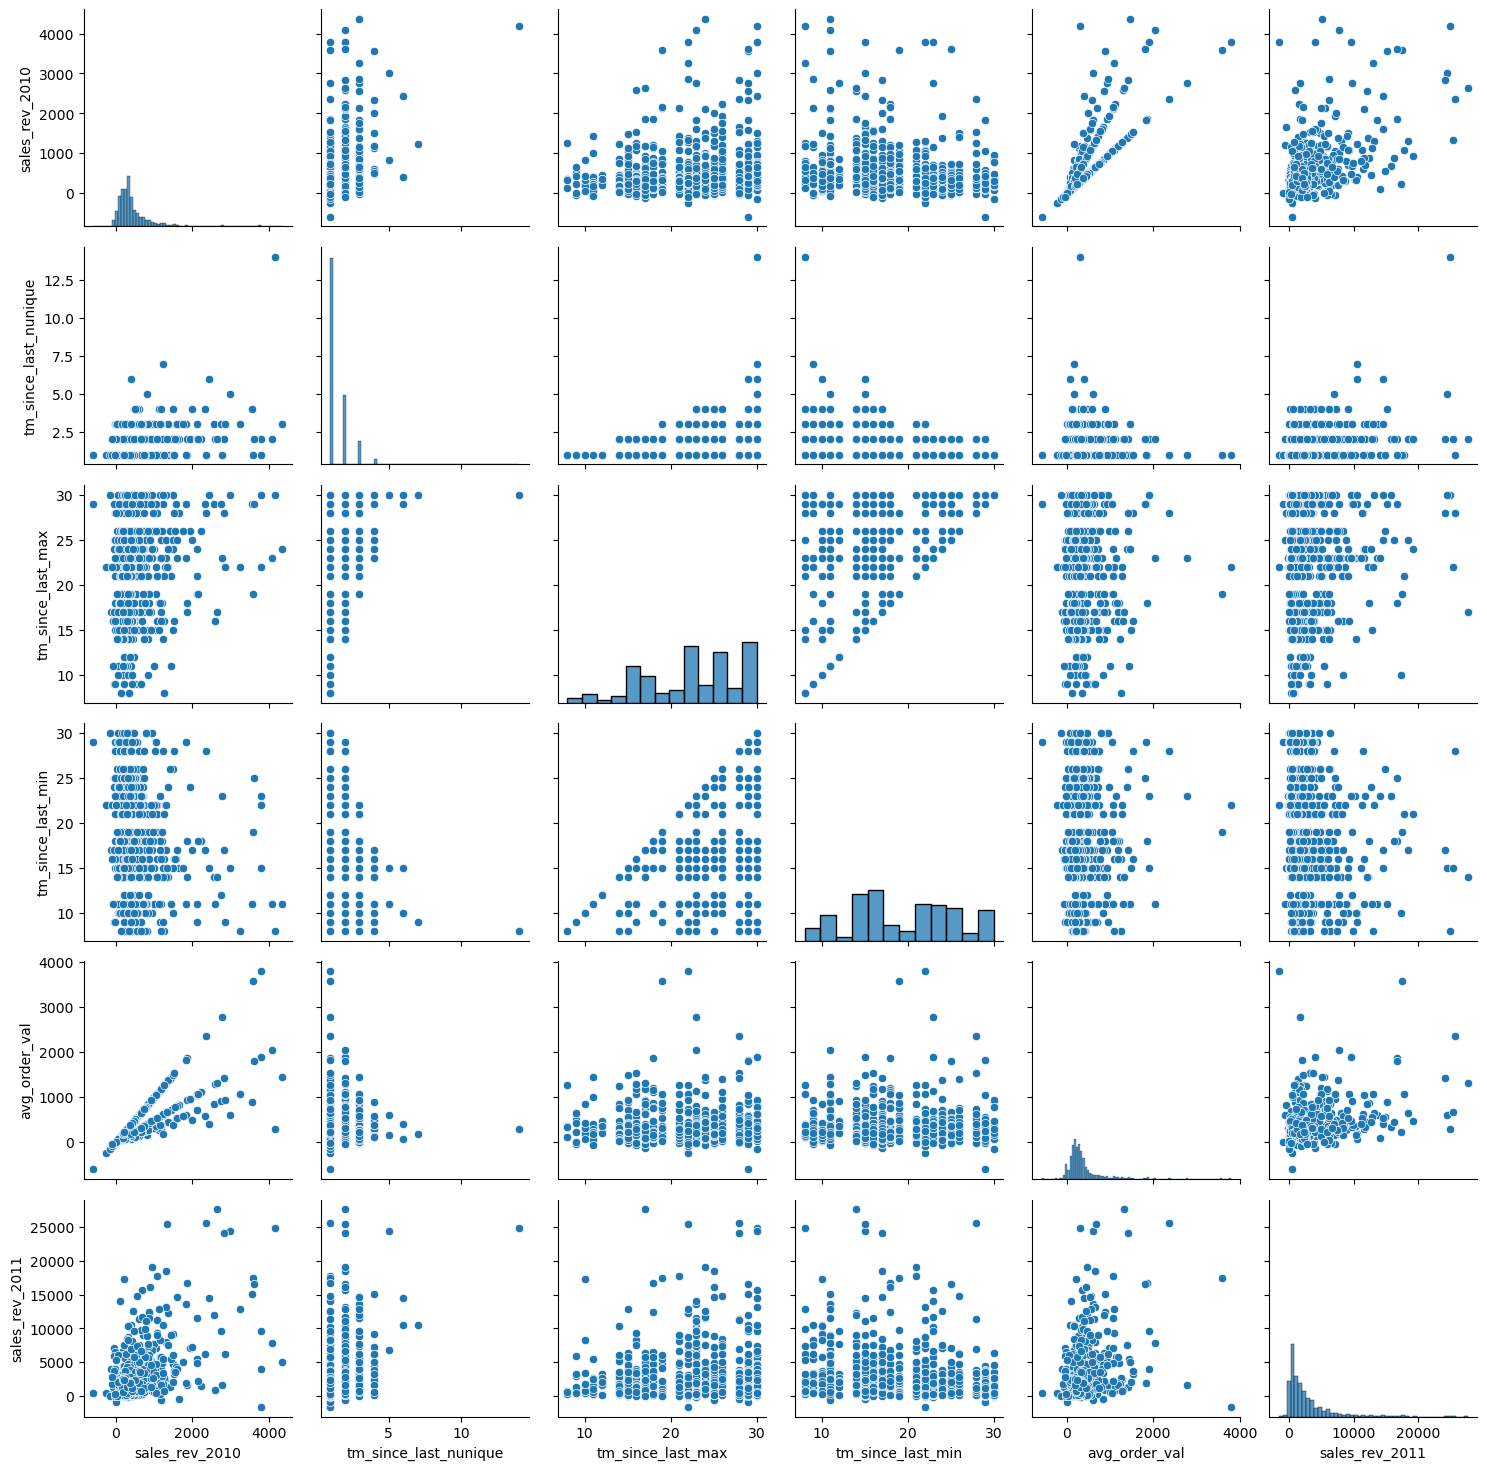

In [14]:
%matplotlib inline
g = sns.PairGrid(ddff)
g.map_diag(sns.histplot)

g.map_offdiag(sns.scatterplot)

In [15]:
# looking at all of the predictor values plotted (above) against the target (bottom row) with histograms of data for each individual column against itself
# hard to get the best sense of how an increase or decrease in one value changes the target
# correlation matrices can be a bit clearer as to the sort of output change we should expect from an increase / decrease in our inputs

ddff.corr()

,sales_rev_2010,tm_since_last_nunique,tm_since_last_max,tm_since_last_min,avg_order_val,sales_rev_2011
sales_rev_2010,1.000000,0.444564,0.122839,-0.224681,0.802634,0.567673
tm_since_last_nunique,0.444564,1.000000,0.300739,-0.418668,-0.022215,0.382967
tm_since_last_max,0.122839,0.300739,1.000000,0.592030,-0.033506,0.064021
tm_since_last_min,-0.224681,-0.418668,0.592030,1.000000,-0.030642,-0.187578
avg_order_val,0.802634,-0.022215,-0.033506,-0.030642,1.000000,0.383691
sales_rev_2011,0.567673,0.382967,0.064021,-0.187578,0.383691,1.000000


In [16]:
# so, looking at the correlation table, specifically the bottom row with our target, we can see that:

# # # as sales_rev_2010 increases, sales_rev_2011 tends to increase the same direction

# # # as tm_since_last_nunique (aka the number of transactions in 2010) increases, sales_rev_2011 tends to increase also

# # # as tm_since_last_max (aka the date of the oldest transaction, counted as days until the end of year 2010) increases, sales_rev_2011 tends to increase also. 
# # # This input only has a very minor effect on the 

# # # as tm_since_last_min (aka the date of the most recent transaction, counted as days until the end of year 2010) decreases, sales_rev_2011 tends to increase also. this 
# # # makes sense, since you'd expect the closer that a customer transacts to the end of 2010, the more likely they are to purchase in 2011

# # # as avg_order_val increases, sales_rev_2011 tends to increase the same direction

### Building a linear regression model to predict the 2011 customer spend from our input variables

In [17]:
# prediction / targets inputs dataframes:
X = ddff[['sales_rev_2010', 'tm_since_last_nunique', 'tm_since_last_max','tm_since_last_min', 'avg_order_val']]
y = ddff[['sales_rev_2011']]

In [18]:
# splitting data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 123)

In [19]:
# instantiating and fitting the linear model with training data
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression()

In [20]:
# just a reminder for the order of the input columns when checking the coefficients, which represent how much an input into the 
# corresponding coeff would need to change to have an increase of 1 in the output target value
# ['sales_rev_2010', 'tm_since_last_nunique', 'tm_since_last_max','tm_since_last_min', 'avg_order_val']

print(lm.coef_)
print('---')
print(lm.intercept_)

[[  3.76991471 778.24712252 -89.9160146   71.81008625  -1.22992236]]
---
[750.33239422]


/var/folders/0g/4l0cmb9j43jgr0cxr8nx6sdm0000gn/T/ipykernel_1328/798336986.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 12500], [0, 12500], 'k-', color = 'r')


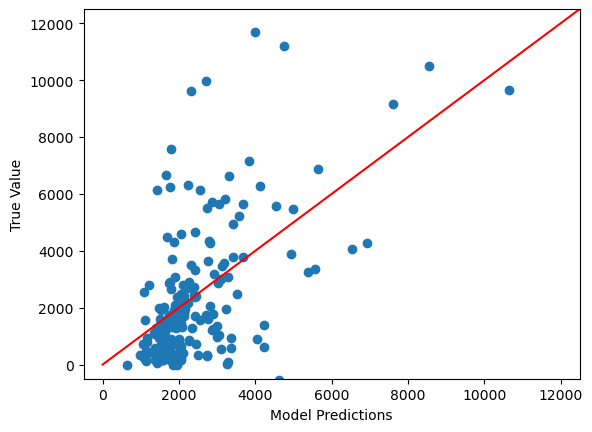

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(lm.predict(X_test),y_test)
plt.xlim(-500,12500)
plt.ylim(-500,12500)
plt.plot([0, 12500], [0, 12500], 'k-', color = 'r')
plt.xlabel('Model Predictions')
plt.ylabel('True Value')
plt.show()

In [22]:
# the viz above just to take a look at the prediction vs. true values
# if the model were perfectly accurate, they'd all fall along the red line with a slope of 1

In [23]:
# putting all the data together
df1 = pd.DataFrame(y_test).reset_index()
df2 = pd.DataFrame(lm.predict(X_test).flatten(),columns=['prediction'])
res_df = pd.merge(df1,df2,left_index=True,right_index=True)
res_df

,customerid,sales_rev_2011,prediction
0,14560,1775.96,2878.848718
1,13327,2872.57,3022.543390
2,17857,25422.64,5635.671806
3,16327,3308.62,2418.245280
4,17019,913.79,1987.331361
...,...,...,...
194,17402,2173.88,2226.145659
195,17950,219.03,1773.095756
196,17228,1550.14,2545.709994
197,16477,1950.06,2153.025707


In [24]:
r2 = sklearn.metrics.r2_score(res_df['sales_rev_2011'],res_df['prediction'])
r2

0.38595203521484955

In [25]:
# Not a great R^2 honestly -- the model only accounts for ~38.5% of the variance of the target variable explained by the dependent variables

In [26]:
from scipy.stats import pearsonr
pearsonr(res_df['prediction'],res_df['sales_rev_2011'])

PearsonRResult(statistic=0.6246646743235978, pvalue=6.247485050681704e-23)

In [27]:
# The pearson R score results are decent, at around ~62.4, the first number
# (which indicates there is a decent correlation of the model's prediction values to the actual target values) 
# and a very low p-value (the second number), which indicates the probability of seeing such a relationship if the two number value sets weren't related